### Steve's variable lag 

VARIABLE LAG  
Rand() returns a random number uniformly distributed from -1 to 1  
Rand01() returns a random number uniformly distributed from 0 to 1  
hyperparameter Switch_prob is a real number between 0 and 1 (try 0.1)  
delta_lag is an integer -1 or 1  
hyperparameter N is an integer  
lag is an integer  
```
P(0) = 0  
For n=1 to N-1  
	P(n) = P(n-1) + Rand()  
lag = 0  
For n=0 to N-1  
	If Rand01() < Switch_prob then  
		If Rand01() < 0.5 then  
			Delta_lag = -1  
		Else  
			Delta_lag = 1  
		lag = lag + Delta_lag  
	If n+lag < 0 then   
		Q(n) = P(0)  
	Else If n+lag >N-1 then  
		Q(n) = P(N-1)  
	Else  
	Q(n) = P(n+lag)  
```


In [20]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

import random
import math
from pathlib import Path
from typing import Tuple, List

import numpy as np
import torch
from torch.optim import AdamW
import pandas as pd
from icecream import ic

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.callbacks import TFMProgressBar
from darts.metrics import mape, smape
from darts.models import BlockRNNModel

from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt

# update pandas settings to display 50 columns
pd.set_option("display.max_columns", 50)

# for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
seed_everything(seed)

42

The following imports and setttings  
  
import logging  
import warnings  
logging.disable(logging.CRITICAL)  
warnings.filterwarnings("ignore")  
  
will disable this output:  
```
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | fc              | Sequential       | 130    | train
-------------------------------------------------------------

2.9 K     Trainable params  
0         Non-trainable params  
2.9 K     Total params  
0.012     Total estimated model params size (MB)  
8         Modules in train mode  
0         Modules in eval mode  
/usr/local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch
```

In [2]:
import logging
import warnings
logging.disable(logging.CRITICAL)
warnings.filterwarnings("ignore")

Create funtions for making and plotting p and q

In [3]:
def create_scaled_random_array(n_values: int) -> np.ndarray:
    """
    Creates a random ndarray of shape (n_values, 1), scaled between 0 and 1.

    Parameters:
    n_values (int): The number of points in the array.

    Returns:
    numpy.ndarray: A scaled random ndarray with the first index set to 0.0.
    """
    random_values = np.random.uniform(-1, 1, n_values).astype(np.float32)
    random_values[0] = 0.0
    return random_values


def create_simple_lag_array(input_array: np.ndarray, lag: int) -> np.ndarray:
    """
    Creates a lagged version q of the input array.  The lag is a positive or negative integer.

    Parameters:
    input_array (numpy.ndarray): The input array.
    lag (int): The lag to apply.

    Returns:
    numpy.ndarray: The lagged array.
    """
    q = np.zeros_like(input_array).astype(np.float32)
    n_values = len(input_array)
    for i in range(n_values - 1):
        if i + lag < 0:
            q[i] = input_array[0]
        elif i + lag >= n_values - 1:
            q[i] = input_array[i - 1]
        else:
            q[i] = input_array[i + lag]
    return q


def create_variable_lag_array(
    input_array: np.ndarray, switch_prob: float
) -> Tuple[np.ndarray, List[int]]:
    """Create an array with variable time lags applied to the input array.

    This function generates a new array where each element is taken from the input array
    with a dynamically changing lag. The lag changes randomly based on the switch probability.
    lags can be positive or negative.

    Parameters
    ----------
    input_array : np.ndarray
        The input array to apply variable lags to
    switch_prob : float
        Probability (between 0 and 1) of changing the lag at each step

    Returns
    -------
    Tuple[np.ndarray, List[int]]
        - np.ndarray: Array of same shape as input with variable lags applied
        - List[int]: List of lags used at each position

    Notes
    -----
    - When lag causes index to go below 0, first element is used
    - When lag causes index to exceed array length, last element is used
    - Lag changes by +1 or -1 with equal probability when a switch occurs
    """
    lags = []
    n_values = len(input_array)
    q = np.zeros_like(input_array).astype(np.float32)

    # Generate q with variable lag
    lag = 0
    for i in range(n_values):
        if np.random.uniform(0, 1) < switch_prob:
            if np.random.uniform(0, 1) < 0.5:
                delta_lag = -1
            else:
                delta_lag = 1
            lag += delta_lag

        lags.append(lag)
        if i + lag < 0:
            q[i] = input_array[0]
        elif i + lag >= n_values - 1:
            q[i] = input_array[n_values - 1]
        else:
            q[i] = input_array[i + lag]
    print(f"Last value of input_array = {input_array[n_values - 1]}")
    return q, lags


def plot_simple_lag_p_q(p: np.ndarray, q: np.ndarray, title: str = "") -> None:
    """
    Plots p and q arrays with a simple lag.

    Parameters:
    p (numpy.ndarray): The first time series.
    q (numpy.ndarray): The second time series.
    title (str): The title of the plot (default is an empty string).

    Returns:
    None
    """
    plt.plot(p, label="p", marker="o")
    plt.plot(q, label="q", marker="x")
    plt.title(title)
    plt.legend()
    plt.show()


def plot_variable_lag_p_q(
    p: np.ndarray, q: np.ndarray, lags: List[int], title: str = ""
) -> None:
    """
    Plots p and q arrays with a variable lag.

    Parameters:
    p (numpy.ndarray): The first time series.
    q (numpy.ndarray): The second time series.
    lags (List[int]): The list of lags.
    title (str): The title of the plot (default is an empty string).

    Returns:
    None
    """
    fig, (ax0, ax1) = plt.subplots(
        nrows=2, figsize=(20, 6), gridspec_kw={"height_ratios": [3, 1]}
    )

    ax0.plot(p, label="p", marker="o")
    ax0.plot(q, label="q", marker="x")
    ax0.set_title("p and q")
    ax0.legend()

    ax1.bar(range(len(lags)), lags)
    ax1.set_title("lags")
    ax1.legend()

    fig.suptitle(title)
    plt.show()

Show p and variable lag q with lags in a dataframe.

In [4]:
N_VALUES = 50
SWITCH_PROB = 0.1

# np.random.seed(seed)
p = np.array([v*10 for v in range(N_VALUES)]).astype(np.float32)
q, lags = create_variable_lag_array(p, switch_prob=SWITCH_PROB)

df = pd.DataFrame({"p": p, "q": q, "lags": lags})
df = df.astype(int)
df = df.T
df

Last value of input_array = 490.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
p,0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490
q,0,10,20,30,40,50,70,80,90,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,300,310,330,340,350,360,380,390,400,410,430,440,450,460,470,480,490,490,490,490,490,490,490
lags,0,0,0,0,0,0,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,4,4,4,4,5,5,5,5,6,6,6,6,6,6,6,6,6,6,6,6,6


Plot p and variable lag q with lags

Last value of input_array = -0.5014155507087708


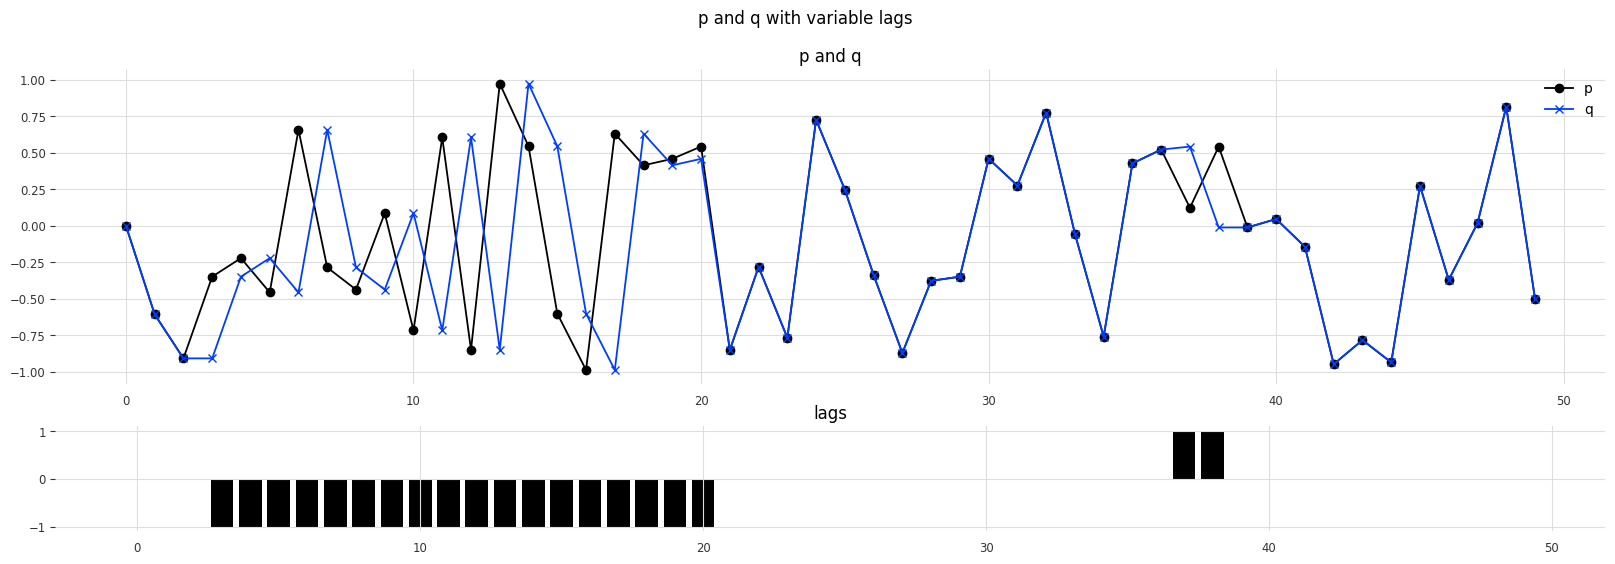

In [5]:
N_VALUES = 50
SWITCH_PROB = 0.1

p = create_scaled_random_array(n_values=N_VALUES)
q, lags = create_variable_lag_array(np.array(p), switch_prob=SWITCH_PROB)
plot_variable_lag_p_q(p, q, lags, "p and q with variable lags")

Function to make a multi-series of p and q pairs   

In [6]:
def create_variable_lag_p_q_series(n_values: int, switch_prob: float) -> Tuple[TimeSeries, List[int]]:
    """
    Creates a TimeSeries with pairs of target (p) and variable lagged (q) time series
    as Darts TimeSeries objects.

    Parameters:
    n_values (int): The number of points in each time series.
    switch_prob (float): The probability of switching the lag.

    Returns:
    TimeSeries: A Darts TimeSeries object, containing a pair of p and lagged q time series.
    """

    p = create_scaled_random_array(n_values=n_values)
    q, lags = create_variable_lag_array(input_array=p, switch_prob=switch_prob)
    p_q_series = TimeSeries.from_values(values=p).stack(
        other=TimeSeries.from_values(values=q)
    )
    p_q_series = p_q_series.with_columns_renamed(
        col_names=["0", "0_1"], col_names_new=["p", "q"]
    )
    return p_q_series, lags

Create p_q_series  
Split into train and validation  
plot train and validation series

Number of examples: 9900
Last value of input_array = -0.972958505153656
max(lags)=17,min(lags)=-15


ic| len(train_series): 9899, len(val_series): 101


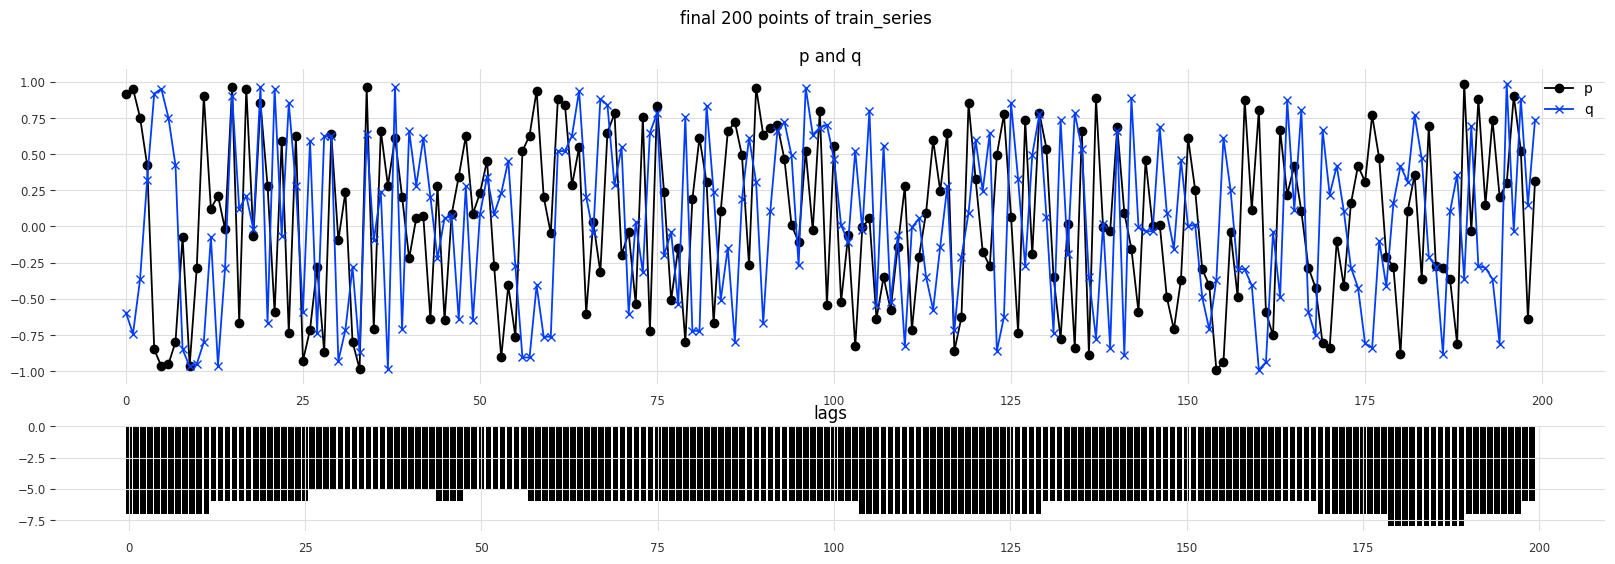

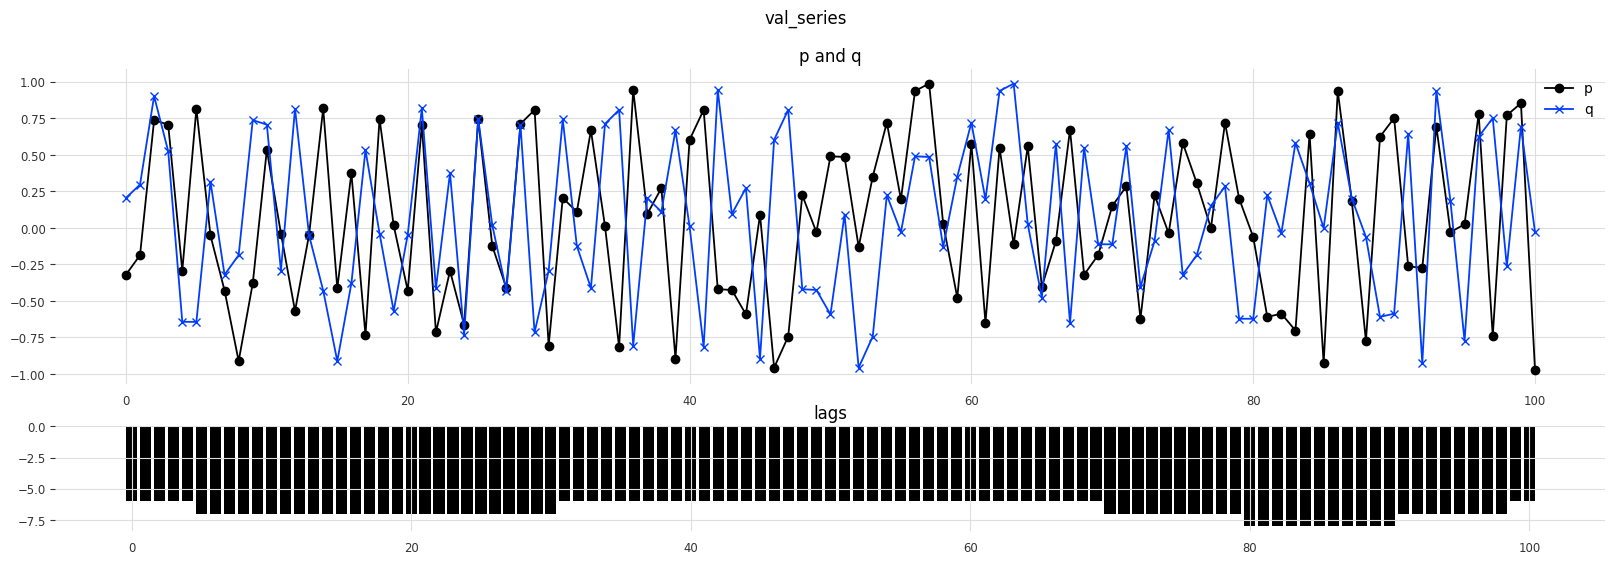

In [13]:
SERIES_LEN = 10_000
INPUT_CHUNK_LEN = 100
OUTPUT_CHUNK_LEN = 1

n_examples = SERIES_LEN - INPUT_CHUNK_LEN - OUTPUT_CHUNK_LEN + 1
print(f"Number of examples: {n_examples}")

# Create  p_q series
p_q_series, lags = create_variable_lag_p_q_series(n_values=SERIES_LEN, switch_prob=0.1)
print(f"{max(lags)=},{min(lags)=}")

# Split into train and validation series
val_series_len = INPUT_CHUNK_LEN + OUTPUT_CHUNK_LEN
train_series, val_series = p_q_series[:-val_series_len], p_q_series[-val_series_len:]
_ = ic(len(train_series), len(val_series))

# Plot the end of the train series
n_end_values = 200
train_series_end = train_series[-n_end_values:]
p = train_series_end["p"].values()
q = train_series_end["q"].values()
lags_end = lags[-n_end_values:]
plot_variable_lag_p_q(p, q, lags_end, f"final {n_end_values} points of train_series")

# Plot the validation series
p = val_series["p"].values()
q = val_series["q"].values()
val_lags = lags[-val_series_len:]
plot_variable_lag_p_q(p, q, val_lags, "val_series")


In [24]:
LOG_DIR = r"/workspaces/darts/examples/darts_logs/variable_lag"

def create_BlockRNNModel(n_epochs, sub_dir="default"):
    tensorboard_logger = TensorBoardLogger(save_dir=LOG_DIR, name=sub_dir)
    pl_trainer_kwargs = {
        "accelerator": "cpu",
        "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        "logger": tensorboard_logger,
    }

    optimizer_kwargs = {"lr": 1e-3}
    return BlockRNNModel(
        model="LSTM",
        input_chunk_length=INPUT_CHUNK_LEN,
        output_chunk_length=OUTPUT_CHUNK_LEN,
        n_epochs=n_epochs,
        batch_size=32,
        optimizer_kwargs=optimizer_kwargs,
        random_state=seed,
        log_tensorboard=True,
        model_name="block_rnn_model",
        pl_trainer_kwargs=pl_trainer_kwargs,
        save_checkpoints=True
    )

In [ ]:
model = create_BlockRNNModel(n_epochs=1200)
model.fit(series=train_series, val_series=val_series)

Training: 0it [00:00, ?it/s]

NameError: name 'exit' is not defined

In [25]:
MODEL_SAVE_PATH = r"./darts_logs/variable_lag/model_save_438"
save_file_path = Path(MODEL_SAVE_PATH + "/model.pt")
save_file_path.parent.mkdir(parents=True, exist_ok=True)
model.save(str(save_file_path))

800 epochs

In [ ]:
pred = model.predict(n=1, series=val_series[:INPUT_CHUNK_LEN])
val_series.plot(label="actual")
pred.plot(label="forecast")
plt.legend()


In [ ]:
pred = model.predict(n=1, series=val_series[:INPUT_CHUNK_LEN])

<Axes: xlabel='time'>

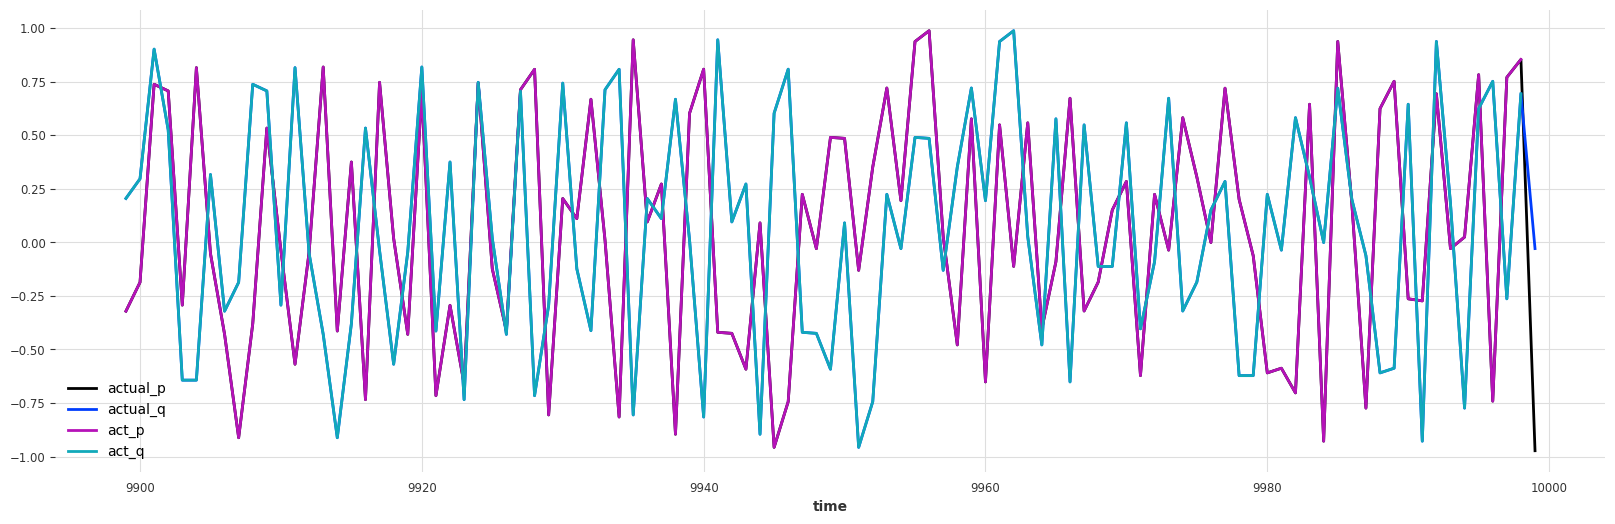

In [36]:
plt.figure(figsize=(20, 6))
val_series.plot(label="actual")
val_series[:INPUT_CHUNK_LEN].plot(label="act")

Last value of input_array = -0.0746404305100441


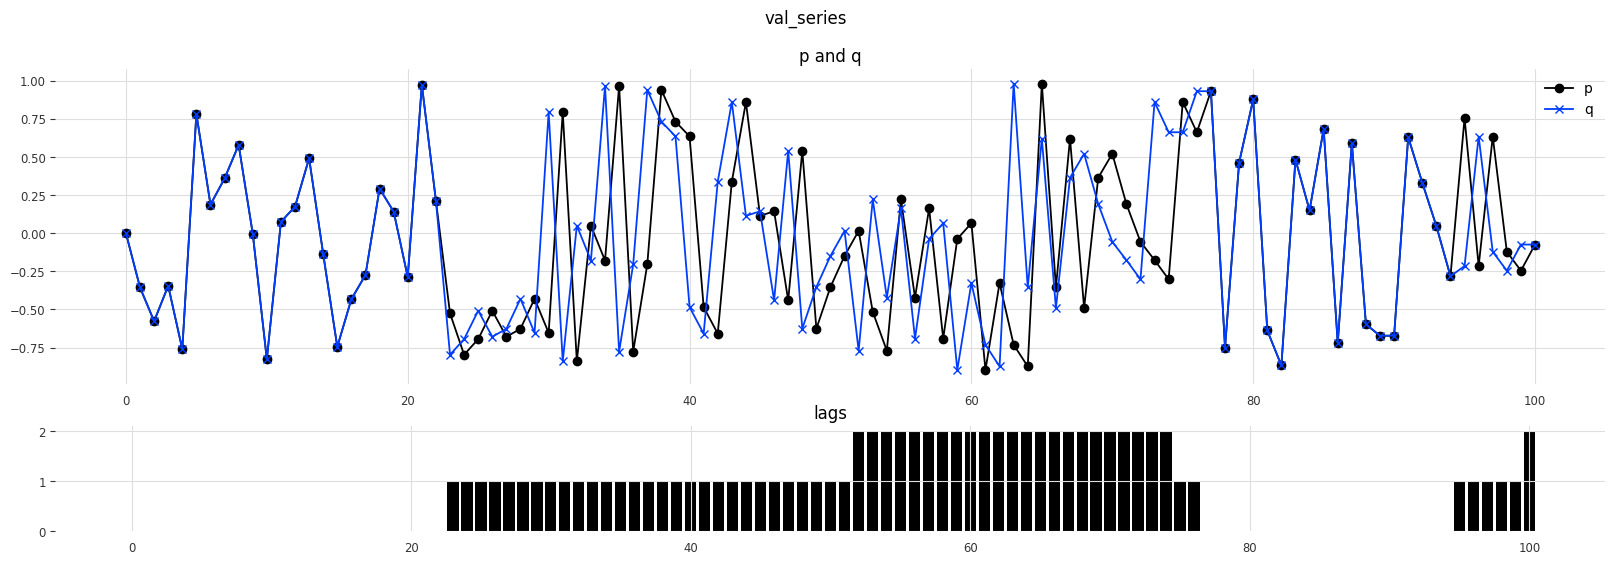

In [34]:
# Create multiple p_q series
new_val_series, lags = create_variable_lag_p_q_series(n_values=val_series_len, switch_prob=SWITCH_PROB)
# pred = model.predict(n=1, series=new_val_series[:INPUT_CHUNK_LEN])
# plt.figure(figsize=(20, 6))

p = new_val_series["p"].values()
q = new_val_series["q"].values()
val_lags = lags[-val_series_len:]
plot_variable_lag_p_q(p, q, val_lags, "val_series")

# new_val_series.plot(label="actual", marker='x')
# pred.plot(label="forecast")
# plt.legend()
# plt.show()